Import libs

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#switching off scientific notation
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

Reading csv file and renaming columns appropriately

In [30]:
df = pd.read_csv('Sweden Load Data 2005-2017.csv')
df.rename({'cet_cest_timestamp':'time','SE_load_actual_tso':'load'},axis='columns',inplace=True)

Converting time columns to datetime and extracting weekday putting it to new column in order to take count of days for RL agent to extract rewards in time.

In [31]:
df['time'] = pd.to_datetime(df['time'],errors='ignore', utc=True)
df['weekday'] = df['time'].dt.weekday

In [32]:
df.head(2)

,time,load,weekday
0,2005-01-01 00:00:00+00:00,15991.34,5
1,2005-01-01 01:00:00+00:00,15673.12,5


In [33]:
test = df.head(50).copy()

In [34]:
class Agent:    
    #class constructor function
    def __init__(self,array_loads,array_weekdays,load_idx=0,charge=4,action_space=np.array(['charge','discharge','wait']),policy='random'):
        #array of our loads
        self.array_loads = array_loads
        #array of weekdays
        self.array_weekdays=array_weekdays
        #load index - zero by default
        self.load_idx = load_idx
        #day index - zero by default
        self.day_idx = load_idx
        #state of charge - full(4 or 400) by default
        self.charge = charge
        #current policy - random by default
        self.policy = policy
        #empty list to collect actual load values
        self.collection_loads = []
        #empty list to collect rewards
        self.collection_rewards = []
        self.action_space = action_space
    
    #function to generate current load from array of loads given current index
    def generate_curr_state(self):
        #assigning current state to load from our array of loads given index
        self.curr_state = self.array_loads[self.load_idx]
        #append to collection of actual load
        self.collection_loads.append(self.curr_state)
        return self.curr_state
    
    #OUR MAIN FUNCTION - MECHANICS IS HERE
    def take_action(self):
        #check whether policy is random
        if self.policy=='random':
            #assign candidate action from uniformly distributed space of actions (wait,charge,discharge)
            candidate_action = np.random.choice(self.action_space, 1)[0]
            #check whether our action is discharge and battery has some charge
            if candidate_action == 'discharge' and self.charge!=0:
                #increase current load index and day index
                self.load_idx+=1
                self.day_idx+=1
                #check whether next load is bigger than current,so that we can legitimately flatten it
                if self.array_loads[self.load_idx] >= self.curr_state:
                    #if yes - we just add current load in place of the inputted to our actual load array
                    self.collection_loads.append(self.curr_state)
                else:
                    #if no - we can't flatten our curve so we write inputted load to actual load array and perform action wait
                    self.curr_state = self.generate_curr_state()
                #we decrease our charge by one / by 100
                self.charge-=1
            #check whether our action is charge and battery is not full
            elif candidate_action == 'charge' and self.charge!=4:
                #increase current load index and day index
                self.load_idx+=1
                self.day_idx+=1
                #check whether next load is smaller than current,so that we can legitimately flatten it
                if self.array_loads[self.load_idx] <= self.curr_state:
                    #if yes - we just add current load in place of the inputted to our actual load array
                    self.collection_loads.append(self.curr_state)
                else:
                    #if no - we can't flatten our curve so we write inputted load to actual load array and perform action wait
                    self.curr_state = self.generate_curr_state()
                #we increase our charge by one / by 100
                self.charge+=1
            #code for all other cases when our action is wait
            else:
                #increase current load index and day index
                self.load_idx+=1
                self.day_idx+=1
                #just write inputted load to actual load array and perform action wait
                self.curr_state = self.generate_curr_state()
        
        #check whether we have crossed to the next dad
        if self.array_weekdays[self.day_idx]== self.array_weekdays[self.day_idx-1]:
            #if no - we just add zero reward
            self.collection_rewards.append(0)
        else:
            #if yes - we calculate our cost for final hour of the day and add to the list of rewards
            cost = 5+0.5*max(self.collection_loads[:-1])+0.05*(max(self.collection_loads[:-1])**2)
            self.collection_rewards.append(cost)
        
        #self.curr_reward = self.collection_rewards[-1]
        #return (self.prev_state,candidate_action,self.curr_reward,self.curr_state)
    def clear_collection_loads(self):
        self.collection_loads = []

create agent

In [35]:
agent1 = Agent(test_df.load.values,test_df.weekday.values)
agent1.generate_curr_state()

NameError: name 'test_df' is not defined

In [36]:
agent1.__dict__

NameError: name 'agent1' is not defined

First action

In [258]:
agent1.take_action()

wait


(15991.34, 'wait', 0, 15673.12)

In [259]:
agent1.__dict__

{'array_loads': array([15991.34, 15673.12, 15431.81, 15326.48, 15468.59, 15717.19,
        15936.22, 16032.7 , 16091.51, 16563.9 , 16997.13, 17120.22,
        17237.21, 17418.9 , 17939.93, 18537.65, 18610.38, 18302.57,
        17935.56, 17465.78, 16950.03, 16335.14, 15708.7 , 15107.03,
        14794.95]),
 'array_weekdays': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 6]),
 'load_idx': 1,
 'day_idx': 1,
 'charge': 4,
 'policy': 'random',
 'prev_state': 15991.34,
 'collection_loads': [15991.34, 15673.12],
 'collection_rewards': [0],
 'curr_state': 15673.12,
 'curr_reward': 0}

Second action

In [260]:
agent1.take_action()

wait


(15673.12, 'wait', 0, 15431.81)

In [261]:
agent1.__dict__

{'array_loads': array([15991.34, 15673.12, 15431.81, 15326.48, 15468.59, 15717.19,
        15936.22, 16032.7 , 16091.51, 16563.9 , 16997.13, 17120.22,
        17237.21, 17418.9 , 17939.93, 18537.65, 18610.38, 18302.57,
        17935.56, 17465.78, 16950.03, 16335.14, 15708.7 , 15107.03,
        14794.95]),
 'array_weekdays': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 6]),
 'load_idx': 2,
 'day_idx': 2,
 'charge': 4,
 'policy': 'random',
 'prev_state': 15673.12,
 'collection_loads': [15991.34, 15673.12, 15431.81],
 'collection_rewards': [0, 0],
 'curr_state': 15431.81,
 'curr_reward': 0}

In [37]:
agent2 = Agent(df.load.values,df.weekday.values)
agent2.generate_curr_state()
for i in range(len(df)-1):
    agent2.take_action()
print(np.mean(agent2.collection_rewards))

1377127.6671184828


In [38]:
agent3 = Agent(df.load.values,df.weekday.values)
agent3.generate_curr_state()
for i in range(len(df)-1):
    agent3.take_action()
print(np.mean(agent3.collection_rewards))

1377405.9406220312


In [83]:
import random 

def discharge(agent, timestamp, load):
    discharge_amount = min(load, agent.battery_charge_speed, agent.battery_level)
    agent.battery_level -= discharge_amount
    agent.history.append((timestamp, load - discharge_amount, 'discharge'))

def charge(agent, timestamp, load):
    charge_amount = min(agent.battery_charge_speed, agent.battery_max - agent.battery_level)
    agent.battery_level += charge_amount
    agent.history.append((timestamp, load + charge_amount, 'charge'))

def wait(agent, timestamp, load):
    agent.history.append((timestamp, load, 'wait'))

ACTION_SPACE = (discharge, charge, wait)

def random_policy(agent, _timestamp, _load):
    return(random.choice(agent.available_actions()))

class Agent2:    
    #class constructor function
    def __init__(self, 
                 battery_level=0,
                 battery_max=400,
                 battery_charge_speed = 100,
                 loads = np.array([]),
                 action_space=ACTION_SPACE, 
                 policy=random_policy,
                 action=wait):
        self.battery_max = battery_max
        self.battery_charge_speed = battery_charge_speed
        self.array_loads = loads
        self.battery_level = battery_level
        self.collection_loads = []
        self.collection_rewards = []
        self.action_space = action_space
        self.action = action
        self.policy = policy
        self.history = []

    def tick(self, timestamp, load):
        self.action(self, timestamp, load)
        self.action = self.policy(self, timestamp, load)

    def available_actions(self):
        result = [wait]
        if self.battery_level > 0: result.append(discharge)
        if self.battery_level < self.battery_max: result.append(charge)
        return result

In [40]:
agent4 = Agent(df.load.values,df.weekday.values)
agent4.generate_curr_state()
for i in range(len(df)-1):
    agent4.take_action()
print(np.mean(agent4.collection_rewards))

1375687.2523693072


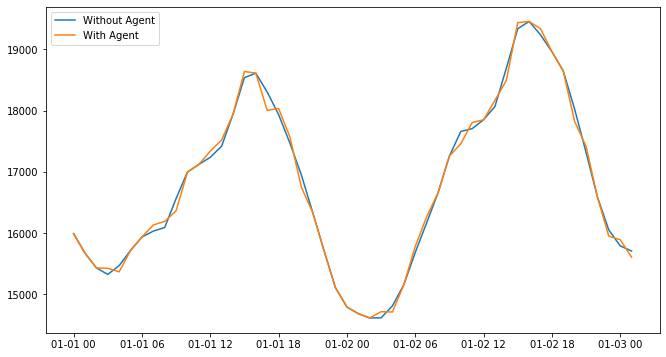

In [46]:
plt.figure(figsize=(11,6))
plt.plot(test.time.values,test.load.values)
# plt.plot(test.time.values,agent4.collection_loads)
plt.plot(test.time.values, actual_history.load)
plt.legend(['Without Agent','With Agent'])
plt.show()
#agent4.collection_loads

In [50]:
agent4 = Agent2(loads = test)
for i, row in test.iterrows():
    agent4.tick(row['time'], row['load'])
actual_history = pd.DataFrame(agent4.history, columns= ['time', 'load', 'past_action'])

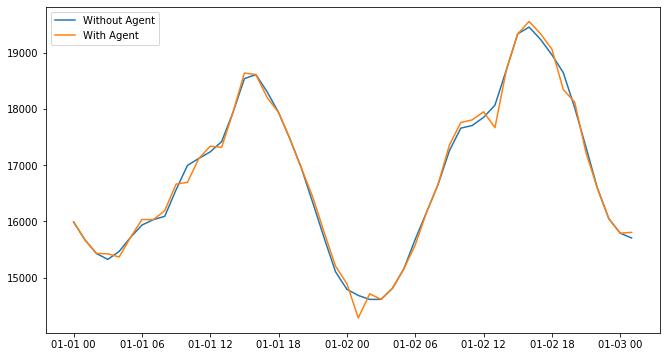

In [51]:
plt.figure(figsize=(11,6))
plt.plot(test.time.values,test.load.values)
plt.plot(test.time.values, actual_history.load)
plt.legend(['Without Agent','With Agent'])
plt.show()

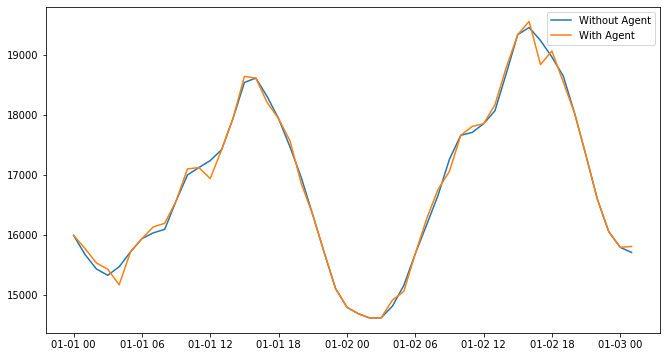

In [65]:
agent4 = Agent2(loads = test, 
                 battery_max=400,
                 battery_charge_speed = 100,)
for i, row in test.iterrows():
    agent4.tick(row['time'], row['load'])
    
actual_history = pd.DataFrame(agent4.history, columns= ['time', 'load', 'past_action'])

plt.figure(figsize=(11,6))
plt.plot(test.time.values,test.load.values)
plt.plot(test.time.values, actual_history.load)
plt.legend(['Without Agent','With Agent'])
plt.show()

In [62]:
def cost(load):
    return np.sum(5 + 0.5 * load + 0.05 * load ** 2)

In [68]:
print("Total cost without agent:", cost(test.load.values))
print("Total cost with random agent:", cost(actual_history.load.values))

Total cost without agent: 709748296.9664352
Total cost with random agent: 709869299.366435


In [74]:
def rule_policy(agent, timestamp, load, min_baseline=15500, max_baseline=18000):
    if load < min_baseline and (charge in agent.available_actions()): return charge 
    if load > max_baseline and (discharge in agent.available_actions()): return discharge
    return wait

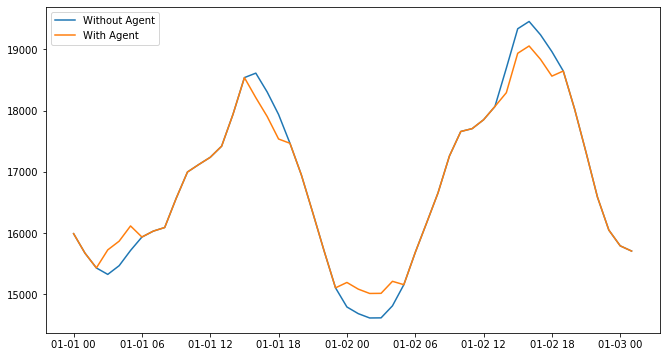

Total cost without agent: 709748296.9664352
Total cost with random agent: 708656835.7664351


In [89]:
agent5 = Agent2(loads = test, 
                 battery_max=2000,
                 battery_charge_speed = 400,
                 policy=rule_policy)

for i, row in test.iterrows():
    agent5.tick(row['time'], row['load'])
    
actual_history = pd.DataFrame(agent5.history, columns= ['time', 'load', 'past_action'])

plt.figure(figsize=(11,6))
plt.plot(test.time.values,test.load.values)
plt.plot(test.time.values, actual_history.load)
plt.legend(['Without Agent','With Agent'])
plt.show()

print("Total cost without agent:", cost(test.load.values))
print("Total cost with random agent:", cost(actual_history.load.values))